In [1]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle

In [2]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)

In [3]:
path = '/auto/data2/eTheremin/ALTAI/ALTAI_20240902_SESSION_00/'

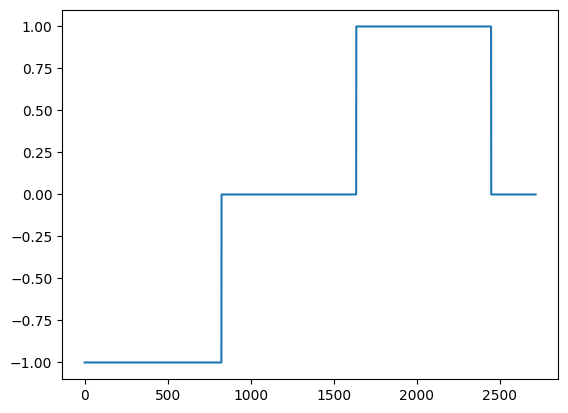

In [4]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)
plt.plot(tt['condition'])
#plt.plot(tt['block'])

In [5]:
data = np.load(path+'headstage_0/data_0.005.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.005.npy', allow_pickle=True)
gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True)

In [6]:
gc

array([27, 20,  5, 10,  3,  6, 31, 29, 21, 28,  1, 24,  8, 23,  7])

In [7]:
warmup = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, 0, 'tail')
tracking_1 = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, 1, 'tracking')
playback_1 = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, 1, 'playback')

In [12]:
#tr = np.hstack((warmup, tracking_1))
tr = playback_1


In [13]:
n = int(len(tr[0])/4)
tracking = np.array(tr)
n = int(len(tracking[0])/4)
first_tr = tracking[:,:n]
second_tr = tracking[:,n:2*n]
third_tr = tracking[:,2*n:3*n]
fourth_tr = tracking[:,3*n:]

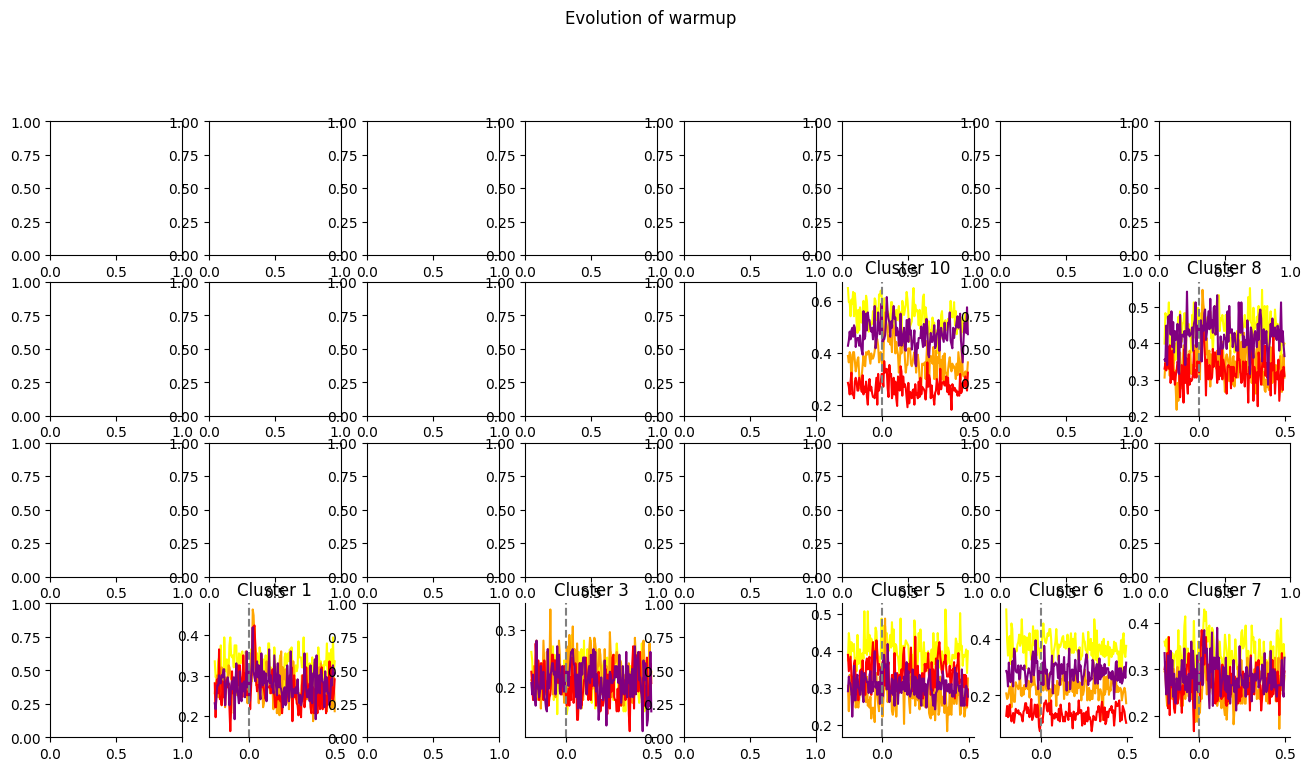

In [14]:

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Evolution of warmup', y=1.02)
plt.subplots_adjust() 
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for cluster in gc:
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(first_tr[cluster], axis=0), c = 'yellow')
        axes[row, col].plot(psth_bins, np.nanmean(second_tr[cluster], axis=0), c = 'orange')
        axes[row, col].plot(psth_bins, np.nanmean(third_tr[cluster], axis=0), c = 'red')
        axes[row, col].plot(psth_bins, np.nanmean(fourth_tr[cluster], axis=0), c = 'purple')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
#plt.savefig(path+'headstage_0/psth_cluster.png')

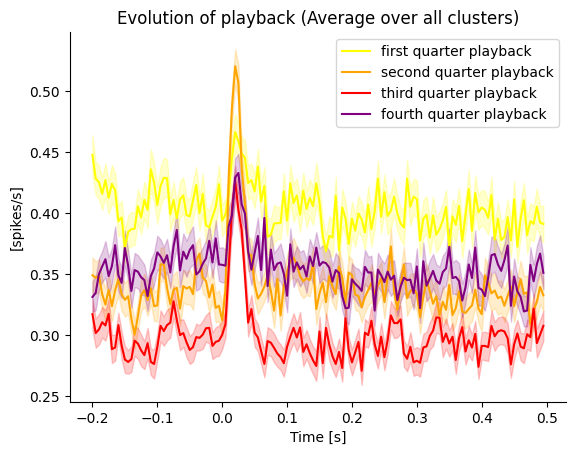

In [16]:
# la moyenne sur tous les clusters
c_tracking = np.nanmean(first_tr, axis=0)
cc_tracking = np.nanmean(second_tr, axis=0)
ccc_tracking = np.nanmean(third_tr, axis=0)
cccc_tracking = np.nanmean(fourth_tr, axis=0)

m_tracking = np.nanmean(c_tracking, axis=0)
mm_tracking = np.nanmean(cc_tracking, axis=0)
mmm_tracking = np.nanmean(ccc_tracking, axis=0)
mmmm_tracking = np.nanmean(cccc_tracking, axis=0)

sem_tr = get_sem(c_tracking)
sem_pb = get_sem(cc_tracking)
sem_ccc = get_sem(ccc_tracking)
sem_cccc = get_sem(cccc_tracking)


plt.plot(psth_bins, m_tracking, c = 'yellow', label = 'first quarter playback')
plt.plot(psth_bins, mm_tracking, c = 'orange',  label = 'second quarter playback')
plt.plot(psth_bins, mmm_tracking, c = 'red',  label = 'third quarter playback')
plt.plot(psth_bins, mmmm_tracking, c = 'purple',  label = 'fourth quarter playback')

plt.fill_between(psth_bins, m_tracking - sem_tr, m_tracking + sem_tr, color='yellow', alpha=0.2)
plt.fill_between(psth_bins, mm_tracking - sem_pb, mm_tracking + sem_pb, color='orange', alpha=0.2)
plt.fill_between(psth_bins, mmm_tracking - sem_ccc, mmm_tracking + sem_ccc, color='red', alpha=0.2)
plt.fill_between(psth_bins, mmmm_tracking - sem_cccc, mmmm_tracking + sem_cccc, color='purple', alpha=0.2)
plt.title('Evolution of playback (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

In [11]:
tracking = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tracking')
tail = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tail')
playback = get_psth(data, features, t_pre, t_post, bin_width, gc, 'playback')

In [ ]:
# Je prends la fin de chaque block de tracking vs la fin de chaque block de pb
n_block = int(np.max([elt['Block'] for elt in features]))
end_tr_total, end_pb_total = [], []

for block in range(1, n_block):
    tr = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, block, 'tracking')
    pb = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, block, 'playback')
    tr = np.array(tr)
    pb = np.array(pb)
    n=int(len(tr[0])/5)
    print(n)
    end_tr = tr[:,4*n:]
    end_pb = pb[:,4*n:]
    end_tr_total.append(end_tr)
    end_pb_total.append(end_pb)
v_end_pb_total = np.hstack(end_pb_total)
v_end_tr_total = np.hstack(end_tr_total)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('end of tracking vs end of playback', y=1.02)
plt.subplots_adjust() 
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for cluster in gc:
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(v_end_tr_total[cluster], axis=0), c = 'red', label = 'tracking')
        axes[row, col].plot(psth_bins, np.nanmean(v_end_pb_total[cluster], axis=0), c = 'black', label = 'playback')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
plt.legend()
plt.show()


In [ ]:
import math
# END tr vs END pb
# Assume bloc_count is the number of blocs
bloc_count = 2  # Set dynamically or based on your actual data

# Determine the number of rows and columns based on bloc_count
cols = 1  # Fixed number of columns (for example)
rows = math.ceil(bloc_count / cols)  # Adjust rows based on the number of blocs

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
fig.suptitle('End of tracking vs end of playback', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between subplots

# Flatten axes array to simplify indexing (in case of 1D or 2D axes)
axes = axes.flatten()

for bloc in range(0,bloc_count+1):  # Loop over the actual number of blocs
    ax = axes[bloc]  # Access the subplot for the current bloc
    print(bloc)
    tr = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, bloc, 'tracking')
    pb = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, bloc, 'playback')

    tr = np.array(tr)
    pb = np.array(pb)
    
    n = int(len(tr[0]) / 5)
    print(n)
    
    end_tr = tr[:, 4 * n:]
    end_pb = pb[:, 4 * n:]

    mc_tr = np.nanmean(end_tr, axis=1)
    mc_pb = np.nanmean(end_pb, axis=1)

    m_tr = np.nanmean(mc_tr, axis=0)
    m_pb = np.nanmean(mc_pb, axis=0)

    sem_tr = get_sem(mc_tr)
    sem_pb = get_sem(mc_pb)

    ax.plot(psth_bins, m_tr, c='red', label='Tracking')
    ax.plot(psth_bins, m_pb, c='black', label='Playback')
    
    ax.fill_between(psth_bins, m_tr - sem_tr, m_tr + sem_tr, color='red', alpha=0.2)
    ax.fill_between(psth_bins, m_pb - sem_pb, m_pb + sem_pb, color='black', alpha=0.2)

    ax.set_title(f'Block {bloc}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('[spikes/s]')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()

# Hide any unused subplots if the grid is larger than the number of blocs
for ax in axes[bloc_count:]:
    ax.axis('off')

plt.show()


In [ ]:
import math

# Assume bloc_count is the number of blocs
bloc_count = 2  # Set dynamically or based on your actual data

# Determine the number of rows and columns based on bloc_count
cols = 1  # Fixed number of columns (for example)
rows = math.ceil(bloc_count / cols)  # Adjust rows based on the number of blocs

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
fig.suptitle('Beginning of tracking vs Beginning of playback', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between subplots

# Flatten axes array to simplify indexing (in case of 1D or 2D axes)
axes = axes.flatten()

for bloc in range(0,bloc_count+1):  # Loop over the actual number of blocs
    ax = axes[bloc]  # Access the subplot for the current bloc
    print(bloc)
    tr = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, bloc, 'tracking')
    pb = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, bloc, 'playback')

    tr = np.array(tr)
    pb = np.array(pb)
    
    n = int(len(tr[0]) / 5)
    print(n)
    
    end_tr = tr[:,:n]
    end_pb = pb[:, :n]

    mc_tr = np.nanmean(end_tr, axis=1)
    mc_pb = np.nanmean(end_pb, axis=1)

    m_tr = np.nanmean(mc_tr, axis=0)
    m_pb = np.nanmean(mc_pb, axis=0)

    sem_tr = get_sem(mc_tr)
    sem_pb = get_sem(mc_pb)

    ax.plot(psth_bins, m_tr, c='red', label='Tracking')
    ax.plot(psth_bins, m_pb, c='black', label='Playback')
    
    ax.fill_between(psth_bins, m_tr - sem_tr, m_tr + sem_tr, color='red', alpha=0.2)
    ax.fill_between(psth_bins, m_pb - sem_pb, m_pb + sem_pb, color='black', alpha=0.2)

    ax.set_title(f'Block {bloc}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('[spikes/s]')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()

# Hide any unused subplots if the grid is larger than the number of blocs
for ax in axes[bloc_count:]:
    ax.axis('off')

plt.show()


In [ ]:
import math
#comparer la fin du tracking n avec le debut du playback n
# Assume bloc_count is the number of blocs
bloc_count = 2  # Set dynamically or based on your actual data

# Determine the number of rows and columns based on bloc_count
cols = 1  # Fixed number of columns (for example)
rows = math.ceil(bloc_count / cols)  # Adjust rows based on the number of blocs

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
fig.suptitle('End of tracking vs beginning of playback', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between subplots

# Flatten axes array to simplify indexing (in case of 1D or 2D axes)
axes = axes.flatten()

for bloc in range(0,bloc_count+1):  # Loop over the actual number of blocs
    ax = axes[bloc]  # Access the subplot for the current bloc
    print(bloc)
    tr = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, bloc, 'tracking')
    pb = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, bloc, 'playback')

    tr = np.array(tr)
    pb = np.array(pb)
    
    n = int(len(tr[0]) / 5)
    print(n)
    
    end_tr = tr[:,4 * n:]
    beg_pb = pb[:,:n]

    mc_tr = np.nanmean(end_tr, axis=1)
    mc_pb = np.nanmean(beg_pb, axis=1)

    m_tr = np.nanmean(mc_tr, axis=0)
    m_pb = np.nanmean(mc_pb, axis=0)

    sem_tr = get_sem(mc_tr)
    sem_pb = get_sem(mc_pb)

    ax.plot(psth_bins, m_tr, c='red', label='end Tracking')
    ax.plot(psth_bins, m_pb, c='black', label='end Playback')
    
    ax.fill_between(psth_bins, m_tr - sem_tr, m_tr + sem_tr, color='red', alpha=0.2)
    ax.fill_between(psth_bins, m_pb - sem_pb, m_pb + sem_pb, color='black', alpha=0.2)

    ax.set_title(f'Block {bloc}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('[spikes/s]')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()

# Hide any unused subplots if the grid is larger than the number of blocs
for ax in axes[bloc_count:]:
    ax.axis('off')

plt.show()

In [ ]:
mc_tr = (np.nanmean(v_end_tr_total, axis=1))
mc_pb = (np.nanmean(v_end_pb_total, axis=1))

m_tr = np.nanmean(mc_tr, axis=0)
m_pb = np.nanmean(mc_pb, axis=0)

sem_tr = get_sem(mc_tr)
sem_pb = get_sem(mc_pb)

plt.plot(psth_bins, m_tr, c = 'red', label = ' tracking')
plt.plot(psth_bins, m_pb, c = 'black',  label = ' playback')
plt.fill_between(psth_bins, m_tr - sem_tr, m_tr + sem_tr, color='red', alpha=0.2)
plt.fill_between(psth_bins, m_pb - sem_pb, m_pb + sem_pb, color='black', alpha=0.2)
plt.title('end tracking vs end playback (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

In [46]:
n = int(len(tracking[0])/2)
tracking = np.array(tracking)
playback = np.array(playback)
end_tr = tracking[:,:-100]
beg_pb = playback[:,0:-100]

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('End of tracking vs end of playback', y=1.02)
plt.subplots_adjust() 
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for cluster in gc:
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(end_tr[cluster], axis=0), c = 'red',label = 'tracking')
        axes[row, col].plot(psth_bins, np.nanmean(beg_pb[cluster], axis=0), c = 'black', label = 'playback')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
plt.legend()
#plt.savefig(path+'headstage_0/psth_cluster.png')

In [40]:
n = int(len(tracking[0])/2)
tr_0 = tracking[:,:n]
tr_1 = tracking[:,n:]

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Evolution of tracking', y=1.02)
plt.subplots_adjust() 
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for cluster in gc:
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(tr_0[cluster], axis=0), c = 'orange')
        axes[row, col].plot(psth_bins, np.nanmean(tr_1[cluster], axis=0), c = 'red')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
    
#plt.savefig(path+'headstage_0/psth_cluster.png')

In [ ]:
# la moyenne sur tous les clusters
c_tracking = np.nanmean(tr_0, axis=0)
cc_tracking = np.nanmean(tr_1, axis=0)


m_tracking = np.nanmean(c_tracking, axis=0)
mm_tracking = np.nanmean(cc_tracking, axis=0)

sem_tr = get_sem(c_tracking)
sem_pb = get_sem(cc_tracking)

plt.plot(psth_bins, m_tracking, c = 'orange', label = 'first half tracking')
plt.plot(psth_bins, mm_tracking, c = 'red',  label = 'second half tracking')
plt.fill_between(psth_bins, m_tracking - sem_tr, m_tracking + sem_tr, color='orange', alpha=0.2)
plt.fill_between(psth_bins, mm_tracking - sem_pb, mm_tracking + sem_pb, color='red', alpha=0.2)
plt.title('Tracking (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

In [ ]:
#diiser les blocks en deux 
n_block = int(np.max([elt['Block'] for elt in features]))

for block in range(1, n_block+1):
    tr = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, block, 'tracking')
    pb = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, block, 'playback')
    tr = np.array(tr)
    n = int(len(tr[0])/2)
    tr_0 = tr[:,:n]
    tr_1 = tr[:,n:]
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    fig.suptitle('Evolution of tracking', y=1.02)
    plt.subplots_adjust() 
    num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
    psth_bins = np.arange(-t_pre, t_post, bin_width)
    for cluster in gc:
        if cluster < num_plots: 
            row, col = get_plot_coords(cluster)
            axes[row, col].plot(psth_bins, np.nanmean(tr_0[cluster], axis=0), c = 'orange')
            axes[row, col].plot(psth_bins, np.nanmean(tr_1[cluster], axis=0), c = 'red')
            axes[row, col].axvline(0, c = 'grey', linestyle='--')
            axes[row, col].set_title(f'Cluster {cluster}')
            axes[row, col].spines['top'].set_visible(False)
            axes[row, col].spines['right'].set_visible(False)
    plt.show()
    
    